In [1]:
from hgmca import wavelets_hgmca, hgmca_core, helpers
import healpy as hp
import numpy as np
import pysm3
import pysm3.units as u
import warnings, os
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline
a2r = np.pi/180/60
root_path = os.getcwd()
    
# Pull up a nice Planck colormap
from matplotlib.colors import ListedColormap
colombi1_cmap = ListedColormap(np.loadtxt("Planck_Parchment_RGB.txt")/255.)
colombi1_cmap.set_bad("gray") # color of missing pixels
colombi1_cmap.set_under("white") # color of background, necessary if you want to use

# Running HGMCA to get CMB Reconstruction

__Authors:__ Sebastian Wagner-Carena and Max Hopkins

__Created:__ 1/14/2020

__Goals:__ Show how to go from measurements of the CMB to a reconstructed CMB map using HGMCA. While the example here focuses on the CMB, the steps outlined will work for any set of healpix maps.

__Requirements:__ Follow the installation instructions for the ```hgmca``` package. This demo notebook also generates a fairly simple set of simluations using ```pysm```. ```pysm``` can be installed using the command ```pip install pysm3```, however for all the installation options see the [pysm website](https://pysm3.readthedocs.io/en/latest/).

## Generate Healpix Maps

First we have to generate our simulated maps that we will run our analysis on. For this we will use the built in functions of ```pysm```. Our mock observations will span the frequencies of the PLANCK satellite but with much lower resolution.

In [2]:
# We want our maps to be output in micro K_CMB so the CMB prior is simple
output_unit = 'uK_CMB'
# We will preference models with spectral variations. See pysm3 documentation for description of these models.
models = ['d2','s2','a1','f1','c1']
# To showcase the flexibility of the HGMCA code, we will change the nside of our maps based on the frequency.
sky_128 = pysm3.Sky(nside=128, preset_strings=models,output_unit=output_unit)
sky_256 = pysm3.Sky(nside=256, preset_strings=models,output_unit=output_unit)

In [3]:
# Now we can make an input map dict. The path we pass in is aspirational at the moment. We will save the map
# there in a moment.
if not os.path.isdir(root_path + '/temp_data'):
    os.mkdir(root_path + '/temp_data')
def input_map_path(freq):
    return root_path + '/temp_data/temp_map_%d_GHz.fits'%(freq)
# fwhm is in units of arcmin
input_maps_dict = {
    '30':{'band_lim':350,'fwhm':33,'path':input_map_path(30),'nside':128},
    '44':{'band_lim':350,'fwhm':24,'path':input_map_path(44),'nside':128},
    '70':{'band_lim':512,'fwhm':20,'path':input_map_path(70),'nside':256},
    '100':{'band_lim':600,'fwhm':20,'path':input_map_path(100),'nside':256},
    '143':{'band_lim':600,'fwhm':20,'path':input_map_path(143),'nside':256},
    '217':{'band_lim':600,'fwhm':20,'path':input_map_path(217),'nside':256},
    '353':{'band_lim':600,'fwhm':20,'path':input_map_path(353),'nside':256},
    '545':{'band_lim':600,'fwhm':20,'path':input_map_path(545),'nside':256},
    '857':{'band_lim':600,'fwhm':20,'path':input_map_path(857),'nside':256}}

In [4]:
# With the dict populated, we can iterate through it and produce our maps
for freq in input_maps_dict:
    if input_maps_dict[freq]['nside'] == 128:
        freq_map = sky_128.get_emission(float(freq) * u.GHz)[0]
    else:
        freq_map = sky_256.get_emission(float(freq) * u.GHz)[0]
    freq_map = hp.smoothing(freq_map,fwhm=input_maps_dict[freq]['fwhm']*a2r,
                            lmax=input_maps_dict[freq]['band_lim'])
    hp.write_map(input_maps_dict[freq]['path'],freq_map,dtype=np.float64,overwrite=True)

Sigma is 14.013810 arcmin (0.004076 rad) 
-> fwhm is 33.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 10.191862 arcmin (0.002965 rad) 
-> fwhm is 24.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 8.493218 arcmin (0.002471 rad) 
-> fwhm is 20.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 8.493218 arcmin (0.002471 rad) 
-> fwhm is 20.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 8.493218 arcmin (0.002471 rad) 
-> fwhm is 20.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 8.493218 arcmin (0.002471 rad) 
-> fwhm is 20.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 8.493218 arcmin (0.002471 rad) 
-> fwhm is 20.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 8.493218 arcmin (0.002471 rad)

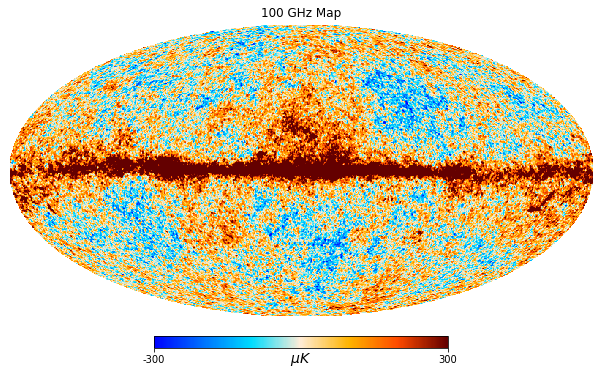

In [5]:
# And we have our simulated data! Let's take a look at one of our maps to make sure we're happy with
# what we have.
hp.mollview(hp.read_map(input_maps_dict['100']['path'],verbose=False,dtype=np.float64),
            title='100 GHz Map',cmap=colombi1_cmap,unit='$\mu K$',min=-300,max=300)

## Run HGMCA
With our simulated maps in hand, we can run the HGMCA algorithm. There are three basic steps:
1. Convert the maps into wavelet coefficients using the WaveletsHGMCA class.
2. Run the HGMCA analysis on the wavelet coefficients using the hgmca_opt function.
3. Extract the source of interest (in our case the CMB) using the WaveletsHGMCA class.

If instead of HGMCA we wanted to run MGMCA, all we would have to do is replace the WaveletsHGMCA class with the WaveletsMGMCA class and the hgmca_opt function with the mgmca function.

In [ ]:
# First we have to select the basic parameters of our analysis.
# The integer used as a basis for scaling the wavelet functions
scale_int = 3
# The minimum wavelet scale to consider. The reamining information will be saved in the scaling coefficients.
j_min = 1
# The maximum level of subdivision to consider. Note that this will also be capped by the actual data (for example
# an nside 256 map is limited to analysis level 5).
m_level = 3
# We need to specify a prefix to write the wavelet maps out to. If we pass the precomputed flag as true, it will
# expect the maps to already be at that prefix. This is useful for large maps were the wavelet computation may take
# some time.
output_maps_prefix = root_path + '/temp_data/demo_'
precomputed = False

# We now pass these arguments into an instance of the WaveletsHGMCA class:
wav_class = wavelets_hgmca.WaveletsHGMCA(m_level)

wav_analysis_maps = wav_class.multifrequency_wavelet_maps(input_maps_dict,output_maps_prefix,scale_int,j_min,
                                                          precomputed=precomputed)

In [ ]:
# With that, we're done with step 1, converting the maps to wavelet coefficients. Next we want to run hgmca on our
# maps.
# The number of sources we want to extract from the data. Note this must be less than the number of frequencies.
n_sources = 5
# The number of epochs of hgmca to run (i.e. how many times to iterate over each level)
n_epochs = 5
# The number of iterations of gmca to run per epoch. A small number is appropriate here (order 100)
n_iterations = 5
# The strength of the prior in the hierarchy 
lam_hier = np.ones(n_sources) * 5e10
# The strength of the global maixing matrix prior. This is how we'll impose the CMB constraint, so we want
# this to be large
lam_global = np.zeros(n_sources)
lam_global[0] = 1e14
# The strength of our sparsity prior. 
lam_s = 50
# Our global mixing matrix prior. The only column that matters here is the first column since we've set the lam_global
# to 0 for all other sources. We want this to be the CMB, which should have no frequency dependence in units of
# K_CMB
A_global = np.ones((wav_analysis_maps['n_freqs'],n_sources))
helpers.A_norm(A_global)
# We can initilize all of the mixing matrices in our hierarchy to a specific value. We will not use that feautre
# here
A_init = None
# Fixing the random seed is useful for the demo
seed = 5
# For CMB source seperation we want to enforce a non-negative mixing matrix. This doesn't mean that the sources
# can't have negative components, just that a source cannot subtract itself (i.e. that sources are emitters
# not absorbers).
enforce_nn_A = True
# Providing a non-zero min_rmse_rate means that ocassionally the hgmca algorithm will update to the minimum rmse
# solution (the best source solution given the mixing matrix and no sparsity constraint). This ends up being a
# useful trick for convergence, so we will use it here
min_rmse_rate = 5
# The save_dict specifies a location to save the outputs to and a rate at which to save the outputs. 
save_dict = {'save_path':root_path + '/temp_data','save_rate':2}

# Now we can run the analysis. This can take ~5 minutes on a standard laptop.
hgmca_analysis_maps = hgmca_core.hgmca_opt(wav_analysis_maps,n_sources,n_epochs,lam_hier,lam_s,n_iterations,
                                           A_init=A_init,A_global=A_global,lam_global=lam_global,seed=seed,
                                           enforce_nn_A=enforce_nn_A,min_rmse_rate=min_rmse_rate,save_dict=save_dict,
                                           verbose=True)

In [ ]:
# And finally we can reconstruct our maps using the output from the hgmca analysis. First we need to detect the cmb
# in the mixing matrix of each of our patches
A_cmb = A_global[:,0]
wav_analysis_maps = hgmca_core.extract_source(hgmca_analysis_maps,A_cmb)

# And now we can pass things back to our wavelet class and get our map
output_maps_prefix_recon = root_path + '/temp_data/recon'
cmb_map = wav_class.wavelet_maps_to_real(wav_analysis_maps,output_maps_prefix_recon)
hp.mollview(cmb_map,title='CMB Reconstruction',cmap=colombi1_cmap,unit='$\mu K$',min=-300,max=300)